<a href="https://colab.research.google.com/github/Jithi2004/Pneumonia_Detection/blob/main/EfficientNet_B3_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install Dependencies
!pip install timm torch torchvision scikit-learn grad-cam --upgrade




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 7.2 MB/s eta

In [ ]:
#Import Libraries
import os
import timm
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from google.colab import drive
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Class Distribution
data_path = "/content/drive/MyDrive/Pneumonia_detection"  # Change to your dataset path
img_paths = glob(f"{data_path}/*/*")
class_counts = Counter([os.path.dirname(img).split("/")[-1] for img in img_paths])

print("Class Distribution:", class_counts)

plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()


NameError: name 'Counter' is not defined

In [ ]:
#Dataset Class
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None, img_exts=[".png", ".jpg", ".jpeg"]):
        self.transform = transform
        self.img_paths = [img for ext in img_exts for img in glob(f"{root_dir}/*/*{ext}")]
        self.class_names = sorted({os.path.dirname(path).split("/")[-1] for path in self.img_paths})
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.class_to_idx[os.path.dirname(img_path).split("/")[-1]]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label



In [ ]:
#Set Up Transforms and Load Data
data_path = "/content/drive/MyDrive/Pneumonia_detection"

transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = PneumoniaDataset(root_dir=data_path, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
print(f"Dataset Loaded! Training: {train_size} | Validation: {val_size}")


Dataset Loaded! Training: 800 | Validation: 200


In [ ]:
 # Define Model, Loss, and Optimizer
 device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [ ]:
#Training
num_epochs = 30
patience = 5
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_acc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "/content/best_pneumonia_model.pth")
        print("✅ Validation loss improved. Model saved.")
    else:
        counter += 1
        print(f"⚠️ No improvement in validation loss for {counter} epoch(s).")

    if counter >= patience:
        print("⏹️ Early stopping triggered.")
        break


Epoch 1/30, Train Loss: 0.9837, Val Loss: 0.7221, Train Acc: 0.8775
✅ Validation loss improved. Model saved.
Epoch 2/30, Train Loss: 0.3602, Val Loss: 0.4537, Train Acc: 0.9313
✅ Validation loss improved. Model saved.
Epoch 3/30, Train Loss: 0.0701, Val Loss: 0.1298, Train Acc: 0.9725
✅ Validation loss improved. Model saved.
Epoch 4/30, Train Loss: 0.1265, Val Loss: 0.0947, Train Acc: 0.9688
✅ Validation loss improved. Model saved.
Epoch 5/30, Train Loss: 0.0493, Val Loss: 0.1767, Train Acc: 0.9875
⚠️ No improvement in validation loss for 1 epoch(s).
Epoch 6/30, Train Loss: 0.0253, Val Loss: 0.0963, Train Acc: 0.9912
⚠️ No improvement in validation loss for 2 epoch(s).
Epoch 7/30, Train Loss: 0.0932, Val Loss: 0.1876, Train Acc: 0.9700
⚠️ No improvement in validation loss for 3 epoch(s).
Epoch 8/30, Train Loss: 0.0341, Val Loss: 0.1386, Train Acc: 0.9850
⚠️ No improvement in validation loss for 4 epoch(s).
Epoch 9/30, Train Loss: 0.0640, Val Loss: 0.1123, Train Acc: 0.9750
⚠️ No improv

In [ ]:
# Load Best Model
model.load_state_dict(torch.load("/content/best_pneumonia_model.pth"))


<All keys matched successfully>


🔹 Accuracy: 0.9750
🔹 Precision: 0.9750
🔹 Recall: 0.9750
🔹 F1 Score: 0.9750

🔹 Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.97      0.97        94
  Pneuomonia       0.97      0.98      0.98       106

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



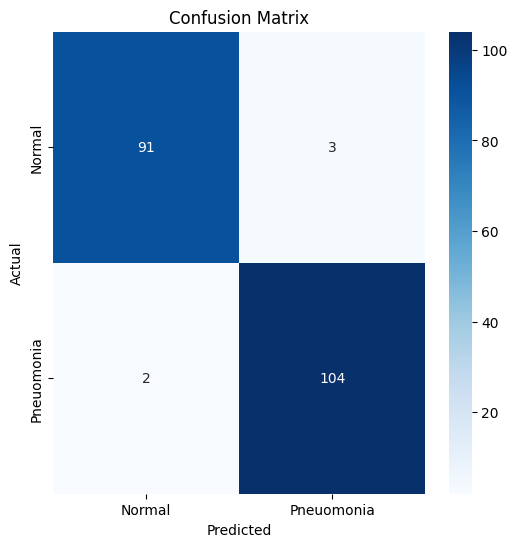

In [ ]:
#Evaluate Model on Validation Set
model.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"\n🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1 Score: {f1:.4f}")
print("\n🔹 Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.class_names))

plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.class_names, yticklabels=dataset.class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


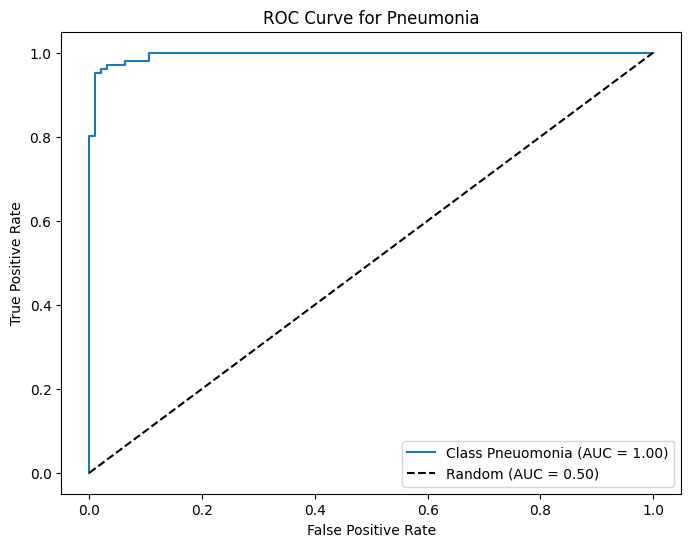

In [ ]:
#ROC Curve Plot
y_true_bin = label_binarize(y_true, classes=np.arange(len(dataset.class_names)))
fpr, tpr, roc_auc = {}, {}, {}
fpr[1], tpr[1], _ = roc_curve(y_true_bin[:, 0], y_scores[:, 1])
roc_auc[1] = auc(fpr[1], tpr[1])

plt.figure(figsize=(8,6))
plt.plot(fpr[1], tpr[1], label=f'Class {dataset.class_names[1]} (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.50)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Pneumonia')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#Grad-CAM++ Visualization Function
def predict_and_visualize_gradcampp(image_path):
    original_image = Image.open(image_path).convert("RGB")
    original_size = original_image.size  # (width, height)

    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

    input_tensor = transform(original_image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        predicted_class_idx = output.argmax(1).item()
        predicted_class = dataset.class_names[predicted_class_idx]

    # Grad-CAM++ Setup
    target_layers = [model.conv_head] if hasattr(model, 'conv_head') else [model.model.conv_head]
    cam = GradCAMPlusPlus(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(predicted_class_idx)])[0]

    # Resize CAM back to original image size
    grayscale_cam_resized = Image.fromarray((grayscale_cam * 255).astype(np.uint8)).resize(original_size, resample=Image.BILINEAR)
    grayscale_cam_resized = np.array(grayscale_cam_resized).astype(np.float32) / 255.0

    # Prepare original image as normalized array
    rgb_img = np.array(original_image).astype(np.float32) / 255.0

    visualization = show_cam_on_image(rgb_img, grayscale_cam_resized, use_rgb=True)

    # Plot original and Grad-CAM++ with same size
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.axis("off")
    plt.title(f"Grad-CAM++: {predicted_class}", color='green')

    plt.tight_layout()
    plt.show()

    return predicted_class


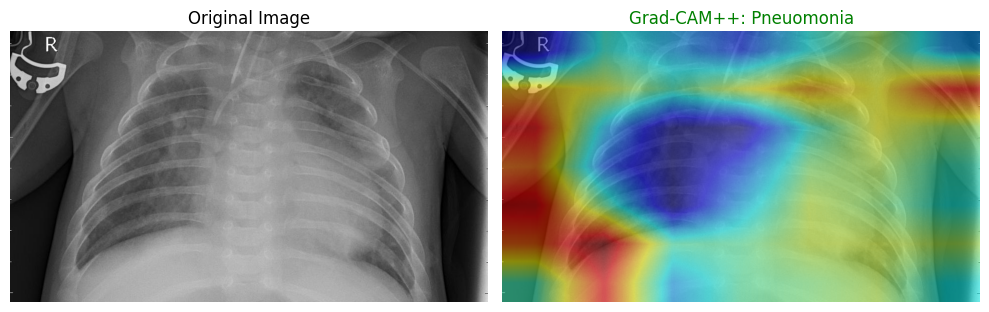

Predicted Disease: Pneuomonia


In [ ]:
test_img_path = "/content/person1_virus_8.jpeg"  # Change as needed
predicted_label = predict_and_visualize_gradcampp(test_img_path)
print("Predicted Disease:", predicted_label)
